# Домашняя работа 2

В этой доамшней работе вам предлагается обучить классификатор, распознающий вид блюда по фотографии. Прямо как на семинаре, только больше разной еды!

 # Home Work 2

In this hw assignment you have to train a classifier to distinguish between different food variations. Just like at our practice, but with more foods variety!

## Но сперва... Теория
Необходимо решить теоретические задачи, используя Latex, внутри этого ноутбука
## But first... Theory
Solve the theoretical problems. Type the solutions here, using Latex

### Задача 1 (2 балла)
### Problem 1 (2 points)

Посчитайте результат применения операции свертки с ядром K к матрице X. Параметры свертки следующие: stride=2, dilation=2, padding=1 (паддинг осуществляется нулями).

Compute the result of convolution operation with kernel K to a matrix X.
Convolution params are: stride=2, dilation=2, padding=1 (padding with zeros)


$        X = \begin{bmatrix}
        1 & 0 & -4 & 2 \\
        5 & 2 & 3 & 0 \\
        -1 & 0 & 1 & 4 \\
        0 & -3 & 2 & -1
    \end{bmatrix}
    K = \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix}
$

#### Решение ================= Solution

$\left|\begin{array}{rrrrrr}0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & -4 & 2 & 0 \\ 0 & 5 & 2 & 3 & 0 & 0 \\ 0 & -1 & 0 & 1 & 4 & 0 \\ 0 & 0 & -3 & 2 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0\end{array}\right|+\left|\begin{array}{cc}2 & 1 \\ -1 & -2\end{array}\right|=\left|\begin{array}{ccc}-4 & -2  \\ 8 & 9 \end{array}\right|$

1) $2 \cdot(-2)=-4$
2) $2 \cdot(-1)=-2$
3) $2 \cdot 1+(-3) \cdot(-2)=2+6=8$
4) $2 \cdot 2+(-3) \cdot(-1)+(-1) \cdot(-2)=4+3+2=9$



# Let's check it out

In [21]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
 
kernel = torch.tensor( 
    [[2, 1], 
     [-1, -2]], dtype=torch.float32) 

kernel = kernel.reshape(1, 1, 2, 2) 
  
image = torch.tensor( 
    [[1, 0, -4, 2],  
     [5, 2, 3, 0],  
     [-1, 0, 1, 4], 
     [0, -3, 2, -1]], dtype=torch.float32)

image = image.reshape(1, 1, 4, 4) 
  
conv = nn.Conv2d(
    in_channels=1, 
    out_channels=1, 
    kernel_size=2, 
    stride=2, 
    padding=1, 
    dilation=2, 
    bias=False
) 
conv.weight = nn.Parameter(kernel) 

output = conv(image) 

print('Output \n',output)

Output 
 tensor([[[[-4., -2.],
          [ 8.,  9.]]]], grad_fn=<ConvolutionBackward0>)


### Задача 2 (2 балла)
### Problem 2 (2 points)

Посчитайте число обучаемых параметров в нейронной сети, архитектура которой выглядит следующим образом:

        model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )
  

In [3]:
model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )

NameError: name 'nn' is not defined

In [20]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

14112

#### Решение =================== Solution

Вам необходимо расписать решение формулами

You need to justify every step

### Conv2d

![alt text](resources/image.png "Title")

params = $M (K \cdot K \cdot D)+ M =3\left(5^2-3\right)+3=228$

### BatchNorm2d

$y=\frac{x-\mathrm{E}[x]}{\sqrt{\operatorname{Var}[x]+\epsilon}} * \gamma+\beta$

params = 2 ($\gamma, \beta$)

### LeakyRelu

params = 0

### Практическое задание
### Practical problem

Вам необходимо решить задачу многоклассовой классификации для датасета Food101

Solve multicalss classification problem for Food101 dataset

####  Служебный код

In [1]:
import copy
import random
import os
import shutil
import tarfile
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

pd.set_option('display.max_colwidth', None)

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [3]:
url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"

In [4]:
dataset_directory = "datasets"

In [5]:
filepath = os.path.join(dataset_directory, "food101.tar.gz")
download_url(
    url=url,
    filepath=filepath,
)
%time extract_archive(filepath)

food101.tar.gz: 100%|██████████| 4.65G/4.65G [03:26<00:00, 24.2MB/s]   


CPU times: total: 9.53 s
Wall time: 1min 3s


### Dataloaders (1 point)


In [6]:
NUM_WORKERS = os.cpu_count()

def split_data(dataset, val_size=0.2, seed=42):
    """
    """
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)

    return train_data, test_data


def create_dataloaders(
    data_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Используйте ImageFolder для создания датасета или напишите свой класс
  dataset =  torchvision.datasets.ImageFolder(data_dir, transform=transform)

  train_set, test_set = split_data(dataset)

  # Get class names
  class_names =  dataset.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_set,                # dataset from which to load the data
      batch_size=batch_size,    # how many samples per batch to load
      shuffle=True,             # set to True to have the data reshuffled at every epoch
      num_workers=num_workers,  # how many subprocesses to use for data loading
      pin_memory=True,          # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
  )
  test_dataloader = DataLoader(
      test_set,                 # dataset from which to load the data
      batch_size=batch_size,    # how many samples per batch to load
      shuffle=False,            # set to True to have the data reshuffled at every epoch
      num_workers=num_workers,  # how many subprocesses to use for data loading
      pin_memory=True,          # If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
  )

  return train_dataloader, test_dataloader, class_names

In [7]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [8]:
from pathlib import Path

data_path = Path(dataset_directory)
image_path = data_path / "food-101" / "images"
image_path

WindowsPath('datasets/food-101/images')

 Опишите трасформы. Можно добавить аугментаций для лучшего результата.

 Можете использовать библиотеку  Albumentation или torchvision

  Не забудьте отмасштабировать размер картинов и нормализовать их

In [9]:
# image_size for fit model
image_size = 224

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])


In [10]:
# creating dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    data_dir=image_path, 
    transform=manual_transforms,
    batch_size=32
)
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

 #### Train function (2 points)


Напишите функцию трейна. Мы делали нечто похожее на семинаре

In [11]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
      
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Do the rest
    # Hint: torch.no_grad() / torch.inference_mode()
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        test_pred_logits = model(X)
        
        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()
        
        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
      
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      
      test_loss, test_acc = test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device)

      # Print out what's happening
      print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)


      torch.save({
              'epoch': epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss_fn,
              }, f"{epochs}_iter.pth")

    # Return the filled results at the end of the epochs
    return results

Выберете модель из доступных

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torchvision.models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')
model = model.to(device)

### Let's have a look at the model

In [14]:
summary(model=model,
        input_size=(32, 3, image_size, image_size), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   648                  True
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   48                   True
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24, 112

Заморозьте некоторые слои или обучайте модель целиком

In [30]:
###
### Выберете слои, через которые не будут течь градиенты
###

for param in model.features.parameters():
    param.requires_grad = False

In [31]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape, # same number of output units as our number of classes
        bias=True
        )).to(device)

### Train (1 point)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 40

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8094 | train_acc: 0.5428 | test_loss: 1.3062 | test_acc: 0.6590
Epoch: 2 | train_loss: 1.1219 | train_acc: 0.6988 | test_loss: 1.0830 | test_acc: 0.7144
Epoch: 3 | train_loss: 0.9018 | train_acc: 0.7540 | test_loss: 1.0397 | test_acc: 0.7287
Epoch: 4 | train_loss: 0.7481 | train_acc: 0.7908 | test_loss: 0.9377 | test_acc: 0.7543
Epoch: 5 | train_loss: 0.6166 | train_acc: 0.8231 | test_loss: 0.9823 | test_acc: 0.7540
Epoch: 6 | train_loss: 0.5160 | train_acc: 0.8514 | test_loss: 0.9605 | test_acc: 0.7567
Epoch: 7 | train_loss: 0.4370 | train_acc: 0.8711 | test_loss: 1.0221 | test_acc: 0.7602
Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8870 | test_loss: 1.0622 | test_acc: 0.7539
Epoch: 9 | train_loss: 0.3187 | train_acc: 0.9019 | test_loss: 1.0317 | test_acc: 0.7634
Epoch: 10 | train_loss: 0.2782 | train_acc: 0.9129 | test_loss: 1.1144 | test_acc: 0.7550
Epoch: 11 | train_loss: 0.2514 | train_acc: 0.9209 | test_loss: 1.0997 | test_acc: 0.7643
Epoch: 12 | train_l

### Results (2 points in total)
Отрисуйте графики лосса для трейна и валидации

Продемонстрируйте работу сетки на каких-нибудь картинках. Помните, что для тестирования лучше иметь отдельный тестовый сет. Для этого либо сами, либо с помощью кода, который был на прошлом семинаре, скачайте несколько фотографий с едой и попробуйте распознать ее.

Либо заранее отложите некоторое кол-во фотографий в тестовую выборку. Из кода должно быть понятно, что вы это сделали.

Это, например, можно сделать, поделив data_test на две выборки с помощью функции split_data, которая у вас есть




#### Graphs (1 point)
Plot graphs for train and val loss

Графикии трейн и вал лосса

Text(0, 0.5, 'acc')

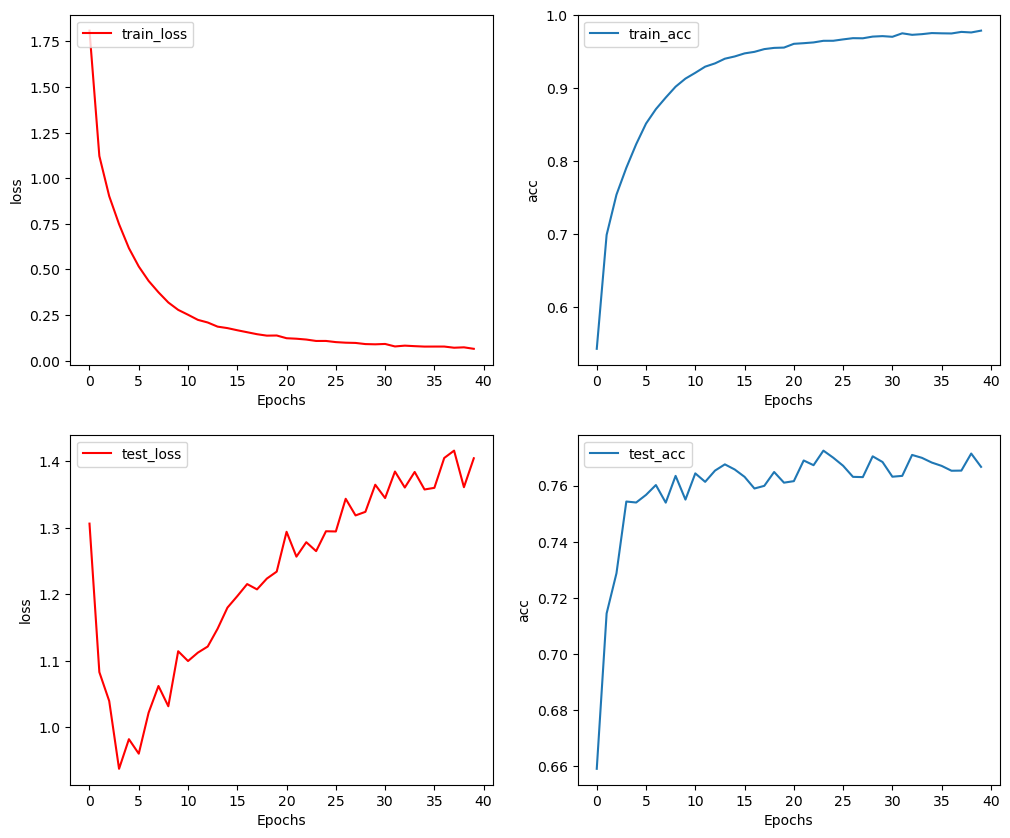

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(results["train_loss"], 'r', label="train_loss")
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('loss')

axes[0, 1].plot(results["train_acc"], label="train_acc")
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('acc')

axes[1, 0].plot(results["test_loss"], 'r', label="test_loss")
axes[1, 0].legend(loc='upper left')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('loss')

axes[1, 1].plot(results["test_acc"], label="test_acc")
axes[1, 1].legend(loc='upper left')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('acc')

#### Demonstration (1 point)

 Покажите качество работы модели, прогнав несколько фотографий через нее

In [21]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

In [23]:
import requests

def download_image(path: Path, url: str):
    if not path.is_file():
        with open(path, "wb") as f:
            # When downloading from GitHub, need to use the "raw" file link
            request = requests.get(url)
            print(f"Downloading {path}...")
            f.write(request.content)
    else:
        print(f"{path} already exists, skipping download.")

test_images\hot-dog.jpeg already exists, skipping download.


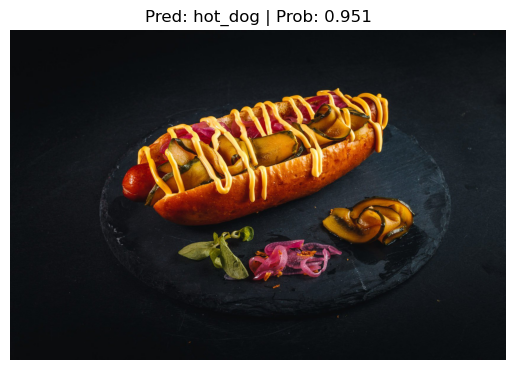

In [26]:
# Setup custom image path
custom_image_path = Path(os.path.join("test_images","hot-dog.jpeg"))
url_link = "https://slkfood.ru/wp-content/uploads/2023/03/Хот-дог-2.jpg"
# Download the image if it doesn't already exist
download_image(custom_image_path, url_link)
# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

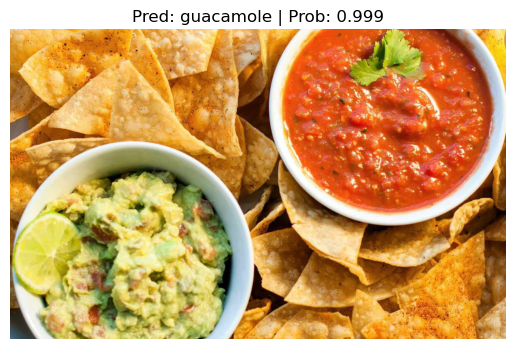

In [29]:
# Setup custom image path
custom_image_path = Path(os.path.join("test_images","nachos.jpeg"))
url_link = "https://avatars.dzeninfra.ru/get-zen_doc/1648379/pub_5d810e19bc251400ae351c4c_5d8118fb32335400af4cd44f/scale_1200"
# Download the image if it doesn't already exist
download_image(custom_image_path, url_link)
# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

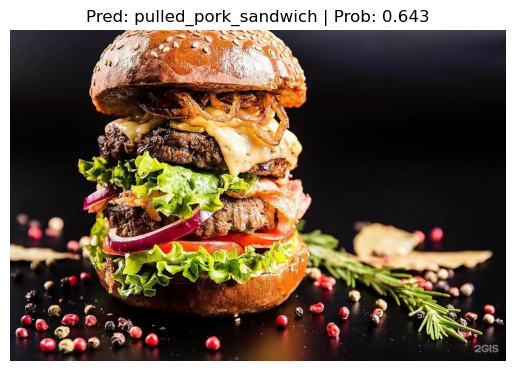

In [30]:
# Setup custom image path
custom_image_path = Path(os.path.join("test_images","burger.jpeg"))
url_link = "https://gas-kvas.com/grafic/uploads/posts/2023-09/1695925240_gas-kvas-com-p-kartinki-burger-11.jpg"
# Download the image if it doesn't already exist
download_image(custom_image_path, url_link)
# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

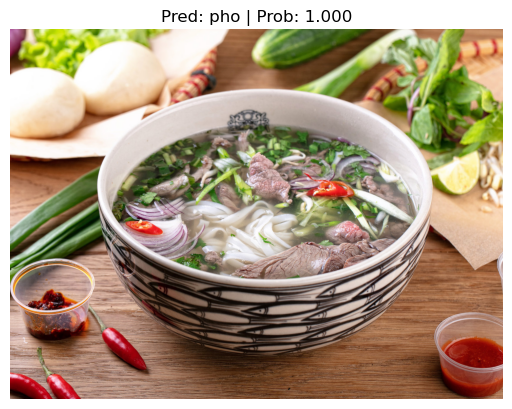

In [34]:
# Setup custom image path
custom_image_path = Path(os.path.join("test_images","pho-bo.jpeg"))
url_link = "https://smapse.ru/storage/2021/06/pho-bo-smapse-eda.jpg"
# Download the image if it doesn't already exist
download_image(custom_image_path, url_link)
# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

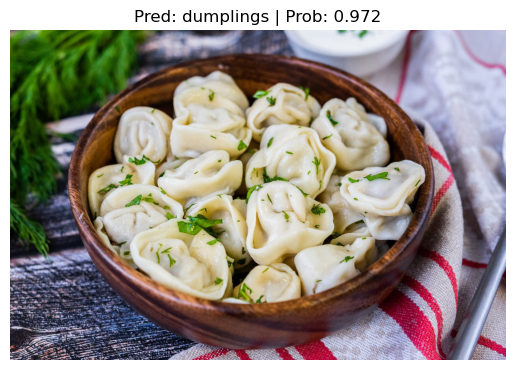

In [36]:
# Setup custom image path
custom_image_path = Path(os.path.join("test_images","pelmeni.jpeg"))
url_link = "https://mykaleidoscope.ru/x/uploads/posts/2022-10/1666235852_64-mykaleidoscope-ru-p-salat-s-pelmenyami-instagram-67.jpg"
# Download the image if it doesn't already exist
download_image(custom_image_path, url_link)
# Predict on custom image
pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)